In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.optim as optim

In [ ]:
batch_size=128 #define the size of a batch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #set the device as cuda to use GPU power
print(f'Using {device}.') #check the working device

Using cuda.


In [ ]:
trans = torchvision.transforms.Compose([torchvision.transforms.Resize((100,100)),torchvision.transforms.ToTensor()])
# set the intial processing of the data, resize the images to 100*100 so that the model can learn from more detail
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=trans)
train_iter = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=trans)
test_iter = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
# load the training set and the testing set

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class_labels=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
X, y = next(iter(train_iter)) # Requests the first training batch
print(X.size())
print(y.size())
# check the size of the loaded tensor

torch.Size([128, 3, 100, 100])
torch.Size([128])


#IntermediateBlock
The IntermediateBlock receives a list "L" as input.  
The "L" consists of two parts.  
The first element is a 3-element list, which respectively are in_channel number, out_channel number and number of convolutional layers in this IntermediateBlock.  
The remaining elements are the hyperparameters of the convolutional layers. Each element is a 4-element list, representing a kind of the convolutional layer setting. The elements in each list are respectively number of this kind of convolutional layer, kernal size, stride and padding.  
  

1. AdaptiveAvgPool2d(1,1) is import to calculate the average value of each channel.(vector "m") It is flattened with a Flatten layer and sent to the Fully Connected layer as its input.  
2. "a" works as the weight of each Convolutional layer, who has the same number of elements as the number of Convolutional layers in this IntermediateBlock. It is set as parameter as the output of a Fully Connected layer with Softmax function as activation function so that the value of "a" won't become too large.  

3. The input images go through every convolutional layers in the InrermediateBlock indepentently. Their outputs are BatchNormalized and multipled by the value of its corresponding element of "a".  
4. The results are added together, becoming an image output. At the end of each IntermediateBlock, the added result will go through a ReLU layer to help the following model learn bettter.  

In [ ]:
class IntermediateBlock(torch.nn.Module):
  def __init__(self,L):
    super(IntermediateBlock,self).__init__()
    self.L = L
    self.Convs=torch.nn.ModuleList()
    in_channels=L[0][0]
    out_channels=L[0][1]
    self.bn = torch.nn.BatchNorm2d(L[0][1])
    for i in range(1,len(L)):
      for _ in range(L[i][0]):
        conv = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=L[i][1], stride=L[i][2], padding=L[i][3])
        self.Convs.append(conv)

    self.a=torch.nn.Parameter(torch.ones(L[0][2]),requires_grad=True)
    self.FC = torch.nn.Linear(L[0][0],L[0][2])
    self.relu = torch.nn.ReLU()
    self.channel_avg = torch.nn.AdaptiveAvgPool2d((1, 1))
    self.softmax = torch.nn.Softmax(dim=1)
    self.flatten = torch.nn.Flatten()
  def forward(self, x):
    m=self.channel_avg(x)
    m=self.flatten(m)
    a=self.FC(m)
    a=self.softmax(a)
    x_out = 0
    for i, conv in enumerate(self.Convs):
      x_mid=conv(x)
      x_mid=self.bn(x_mid)
      x_out += a[:, i:i+1,None,None] * x_mid
    return self.relu(x_out)


# OutputBlock
The OutputBlock also take the same "L" as input to set the number of the input units of the Fully Connected layer.  
1. An AdaptiveAvgPool2d layer is set to calculate the average value of each channel of the input image (vector "m"). It goes through a Flatten layer and become the input of the Fully Connected layer.
2. A Fully Connected layer with input units of the same number as the number of the last IntermediateBlock' out_channels and 10 output units will receive "m" as input and output the final result.

In [ ]:
class OutputBlock(torch.nn.Module):
  def __init__(self,L):
    super(OutputBlock,self).__init__()
    self.L=L
    self.Linear1 = torch.nn.Linear(L[(len(L)-1)][0][1],10)
    self.flatten = torch.nn.Flatten()
    self.channel_avg = torch.nn.AdaptiveAvgPool2d((1, 1))

  def forward(self,x):

    m=self.channel_avg(x)
    m=self.flatten(m)
    o = self.Linear1(m)


    return o

# Neural Network Architecture

The model take a "L" as input, containing information about how the InterMediateBlocks and the OutputBlock are built.
1. The input images will first go through a Convolutional layer with 7 * 7 kernel, 2 as stride and 3 as padding, then a BatchNormalization layer, a ReLU layer and a MaxPooling layer with 3 * 3 kernel, 2 as stride and 1 as padding.  
This part is the intial processing of the data.
2. Then the data will be passed to IntermediateBlocks manipulated by the input "L". After each IntermediateBlock, there is a Dropout layer to prevent overfitting.  
3. After that, the result will be passed to the OutputBlock to produce the final result as a 10-dim vector.

In [ ]:
class ZhuNet(torch.nn.Module):
  def __init__(self,L):
    super(ZhuNet, self).__init__()
    self.IntermediateBlocks = torch.nn.ModuleList([IntermediateBlock(L[i]) for i in range(len(L))])
    self.OutputBlock = OutputBlock(L)
    self.Conv = torch.nn.Conv2d(3,L[0][0][0],7,2,3)
    self.bn = torch.nn.BatchNorm2d(L[0][0][0])
    self.relu = torch.nn.ReLU()
    self.maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.drop = torch.nn.Dropout(0.1)
  def forward(self, x):
    xx=self.Conv(x)
    xx=self.bn(xx)
    xx=self.relu(xx)
    xx=self.maxpool(xx)

    for i, inter in enumerate(self.IntermediateBlocks):
      xx = inter(xx)
      xx = self.drop(xx)

    o=self.OutputBlock(xx)

    return o

In [ ]:
def init_weights(m):
  if type(m)== torch.nn.Linear or type(m) == torch.nn.Conv2d:
    torch.nn.init.xavier_uniform_(m.weight)

# Initial Setting
The model contains 4 IntermediateBlocks.  
Different kernal sizes and paddings ensure the block can learn from different views and keep the size of output of each Convolutional layer uniformed.    
1. 64 channels in, 64 channels out, 8 Convolutional layers in total  
4 of them have 3 * 3 kernel, 2 as stride and 1 as padding  
2 of them have 5 * 5 kernel, 2 as stride and 2 as padding  
2 of them have 7 * 7 kernel, 2 as stride and 3 as padding  
  

Using 2 as stride helps to condense the size of feature maps.  
2. 64 channels in, 128 channels out, 6 Convolutional layers in total  
4 of them have 3 * 3 kernel, 1 as stride and 1 as padding  
2 of them have 5 * 5 kernel, 1 as stride and 2 as padding  
3. 128 channels in, 128 channels out, 4 Convolutional layers in total  
4 of them have 3 * 3 kernel, 1 as stride and 1 as padding  
4.  128 channels in, 512 channels out, 4 Convolutional layers in total  
4 of them have 1 * 1 kernel, 1 as stride and 0 as padding  

In [ ]:
L1=[[64,64,8],
  [4,3,2,1],
  [2,5,2,2],
  [2,7,2,3]]

L2=[[64,128,6],
  [4,3,1,1],
  [2,5,1,2]]

L3=[[128,128,4],
  [4,3,1,1]]

L4=[[128,512,4],
  [4,1,1,0]]


L=[L1,L2,L3,L4]

model = ZhuNet(L).to(device)
model.apply(init_weights)

ZhuNet(
  (IntermediateBlocks): ModuleList(
    (0): IntermediateBlock(
      (Convs): ModuleList(
        (0-3): 4 x Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (4-5): 2 x Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        (6-7): 2 x Conv2d(64, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      )
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (FC): Linear(in_features=64, out_features=8, bias=True)
      (relu): ReLU()
      (Pooling): AvgPool2d(kernel_size=3, stride=2, padding=1)
      (channel_avg): AdaptiveAvgPool2d(output_size=(1, 1))
      (softmax): Softmax(dim=1)
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (1): IntermediateBlock(
      (Convs): ModuleList(
        (0-3): 4 x Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4-5): 2 x Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      )
      (bn): BatchN

## Training

In [ ]:
loss = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.8, 0.8))

In [ ]:
def correct(logits, y):
    y_hat = logits.argmax(axis=1)
    return (y_hat == y).float().sum()
def evaluate_metric(model, data_iter, metric):
    c = 0.
    n = 0.
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        logits = model(X)
        c += metric(logits, y)
        n += len(y)
    return float(c / n)*100

In [ ]:
model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
print(f'Training accuracy: {evaluate_metric(model, train_iter, correct)}. Testing accuracy: {evaluate_metric(model, test_iter, correct)}.')

Training accuracy: 9.999999403953552. Testing accuracy: 9.999999403953552.


Early Stop system is utilized. The model training will automatically stop when there has been 25 epochs with no improvement on test_accuracy.


Epoch 1/2000. wait= 0 Training accuracy: 24.077999591827393. Testing accuracy: 24.769999086856842. Best:0.0

Epoch 2/2000. wait= 0 Training accuracy: 57.47799873352051. Testing accuracy: 56.08999729156494. Best:24.769999086856842

Epoch 3/2000. wait= 0 Training accuracy: 59.88999605178833. Testing accuracy: 57.28999972343445. Best:56.08999729156494

Epoch 4/2000. wait= 0 Training accuracy: 61.03399991989136. Testing accuracy: 58.30000042915344. Best:57.28999972343445

Epoch 5/2000. wait= 0 Training accuracy: 75.48199892044067. Testing accuracy: 71.48999571800232. Best:58.30000042915344

Epoch 6/2000. wait= 0 Training accuracy: 72.45199680328369. Testing accuracy: 68.32000017166138. Best:71.48999571800232

Epoch 7/2000. wait= 1 Training accuracy: 75.23599863052368. Testing accuracy: 70.02999782562256. Best:71.48999571800232

Epoch 8/2000. wait= 2 Training accuracy: 64.39599990844727. Testing accuracy: 60.74000000953674. Best:71.48999571800232

Epoch 9/2000. wait= 3 Training accuracy: 7

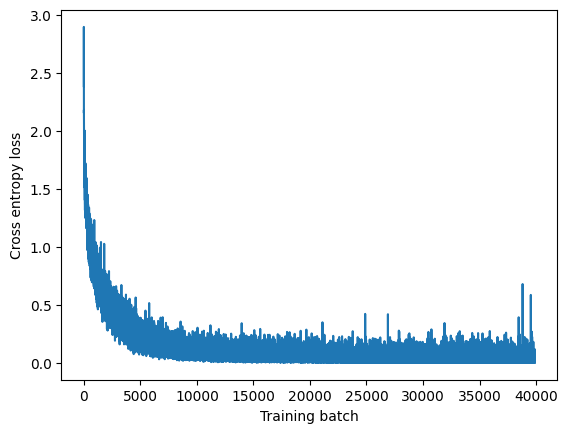

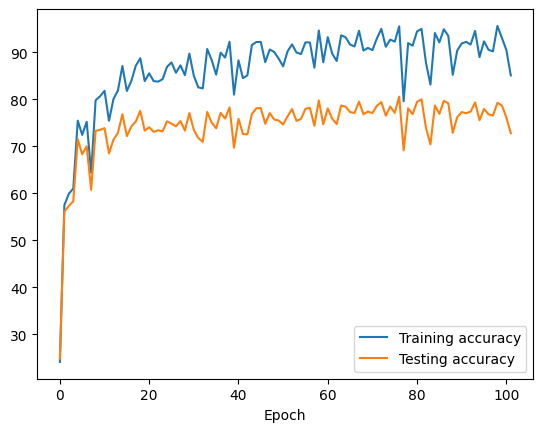

In [ ]:
losses=[]
train_accs=[]
test_accs=[]
num_epochs=2000
best_test_acc = 0.0
patience = 25
improvement_threshold = 0
wait = 0
for epoch in range(num_epochs):
    model.train()
    for X, y in train_iter:
        X, y = X.to(device), y.to(device)
        logits = model(X)

        l = loss(logits, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        losses.append(float(l))

    with torch.no_grad():
        model.eval()
        train_accs.append(evaluate_metric(model, train_iter, correct))
        test_accs.append(evaluate_metric(model, test_iter, correct))
        print(f'\nEpoch {epoch + 1}/{num_epochs}.','wait=',wait,f'Training accuracy: {train_accs[-1]}. Testing accuracy: {test_accs[-1]}.',f'Best:{best_test_acc}')

    current_test_acc = test_accs[-1]
    if current_test_acc > best_test_acc + improvement_threshold:
        best_test_acc = current_test_acc
        wait = 0
        torch.save(model.state_dict(), 'best_model.pth')
        # if there is an improvement, the waiting time will be emptyed, best model and its accuracy will be updated
    else:
        wait += 1

        if wait >= patience:
            print(f'Early stopping triggered at epoch {epoch + 1}.')
            print(f'The Testing accuracy of the best model is: {best_test_acc}.')
            break
        # if the waiting time exceed the patience, the training will end.

plt.plot(losses) # Plots the loss for each training batch
plt.xlabel('Training batch')
plt.ylabel('Cross entropy loss')
plt.show()

plt.plot(train_accs, label='Training accuracy')
plt.plot(test_accs, label='Testing accuracy')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.show()